# [CSCI 3397/PSYC 3317] Lab 3b: Image Registration

**Posted:** Thursday, February 3, 2022

**Due:** Thursday, February 10, 2022

__Total Points__: 5 pts

__Submission__: please rename the .ipynb file as __\<your_username\>_lab3b.ipynb__ before you submit it to canvas. Example: weidf_lab3b.ipynb.

# 1. Image Transformation

## 1.1 Point cloud representation

Lec. 5, Page 14

In [1]:
import numpy as np

im_size = [3,3]
I = 100 * np.arange(np.prod(im_size)).reshape(im_size)

print('Matrix representation:\n', I)

[x,y] = np.meshgrid(np.arange(im_size[0]), np.arange(im_size[1]))

print('------------')
print('Point cloud representation (x,y,I):')
print(np.hstack([x.reshape(-1,1),y.reshape(-1,1),I.reshape(-1,1)]))

Matrix representation:
 [[  0 100 200]
 [300 400 500]
 [600 700 800]]
------------
Point cloud representation (x,y,I):
[[  0   0   0]
 [  1   0 100]
 [  2   0 200]
 [  0   1 300]
 [  1   1 400]
 [  2   1 500]
 [  0   2 600]
 [  1   2 700]
 [  2   2 800]]


# 1.2 Forward warping
The benefit of forward warping is that it's straightforward to visualize what happens to the pixels.

Lec. 5, Page 15-18

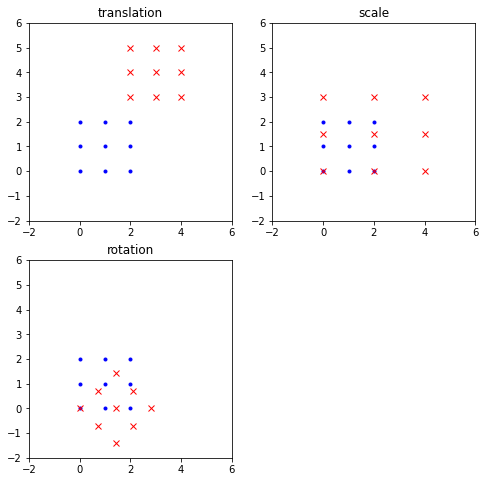

In [2]:
import matplotlib.pyplot as plt

T_trans = np.array([[1,0,2],[0,1,3]])
T_scale = np.array([[2,0,0],[0,1.5,0]])
theta= 45/180*np.pi
T_rotate = np.array([[np.cos(theta),np.sin(theta),0],\
                     [-np.sin(theta),np.cos(theta),0]])


T=[T_trans, T_scale, T_rotate]
names=['translation','scale','rotation']

pos = np.vstack([x.reshape(-1), y.reshape(-1), np.ones(y.size)])

plt.figure(figsize=(8, 8)) 

for i,t in enumerate(T):
    plt.subplot(2,2,i+1)
    plt.plot(x.reshape(-1), y.reshape(-1),'b.')
    # numpy matrix multiplication
    pos2 = np.matmul(t, pos)
    plt.plot(pos2[0], pos2[1],'rx')
    plt.xlim([-2,6])
    plt.ylim([-2,6])
    plt.title(names[i])

# 1.3. Backward warping

The benefit of backward warping is that it's easy to interpolate any transformation with bilinear interpolation. You'll implement the bilinear interpolation in the exercise.

# 2. Transformation estimation

# 2.0 Load and visualize data

Lec. 5, Page 12

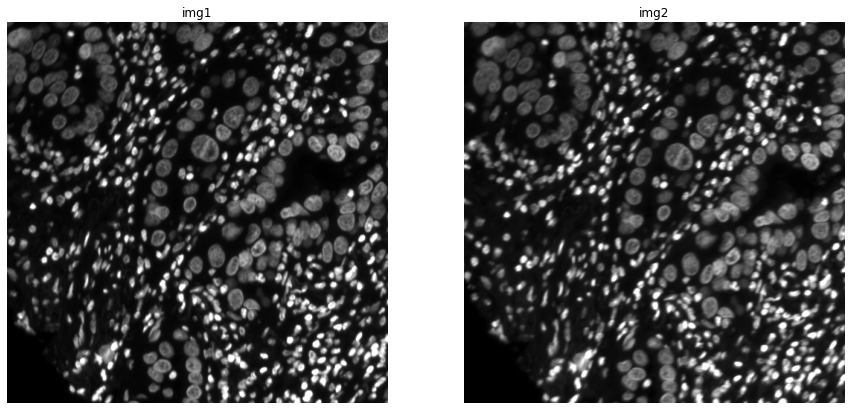

In [3]:
from imageio import volread
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from T_util import * 
# import handy functions in T_util

# "imAdjust()" defined in .../T_util.py
img1 = imAdjust(volread('lab3/exemplar-001-cycle-01.ome.tiff')[0,:512,:512])
img2 = imAdjust(volread('lab3/exemplar-001-cycle-03.ome.tiff')[0,:512,:512])

# "plotImgPair()" defined in .../T_util.py
# hard to tell the difference
plotImgPair(img1, img2, title=['img1', 'img2'])

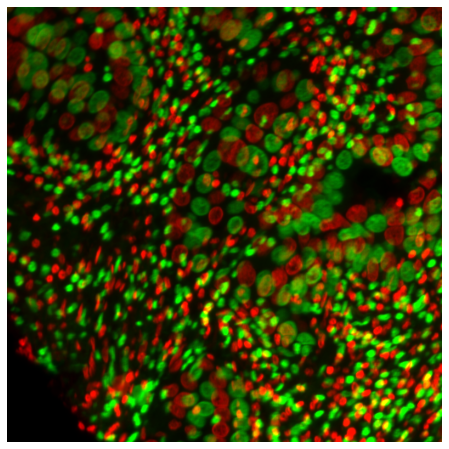

In [4]:
# RGB visualization
sz = img1.shape
out = np.zeros([sz[0], sz[1], 3], np.uint8)
out[:,:, 0] = img1
out[:,:, 1] = img2

plt.figure(figsize=(8, 8)) 
plt.imshow(out);plt.axis('off')
plt.show()

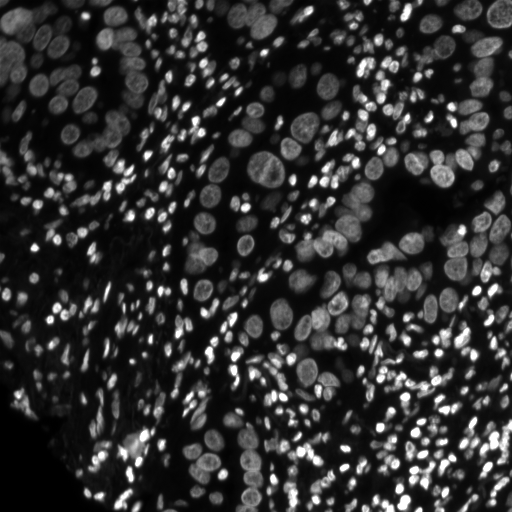

In [5]:
# GIF visualization
# "dispGif()" defined in .../T_util.py
dispGif(img1, img2)

## 2.1 Template matching

Lec. 5, page 42-46

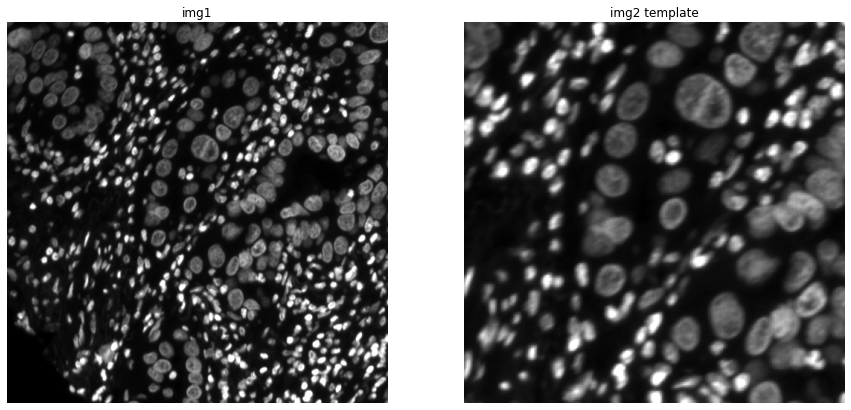

In [6]:
import cv2

crop_start = [128,128]
crop_size = [256,256]
img2_template = img2[crop_start[0] : crop_start[0] + crop_size[0],\
                    crop_start[1] : crop_start[1] + crop_size[1]]

plotImgPair(img1, img2_template, title=['img1', 'img2 template'])

### (a) Cross-correlation (same as convolution, except no flipping kernel)

<img src="https://docs.opencv.org/2.4/_images/math/93f1747a86a3c5095a0e6a187442c6e2a0ae0968.png">

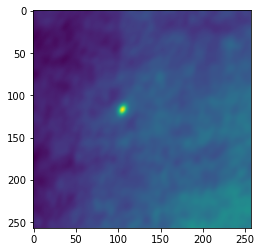

In [7]:
# not too bad for this image, but in general can be bad
# page 44
heatmap_cc = cv2.matchTemplate(img1, img2_template, cv2.TM_CCORR)
plt.imshow(heatmap_cc)

### (b) Normalized Cross-correlation: for each patch, divide the correlations result by the norm of both patches.

<img src="https://docs.opencv.org/2.4/_images/math/6a72ad9ae17c4dad88e33ed16308fc1cfba549b8.png">

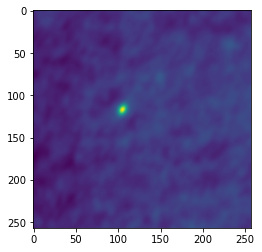

In [8]:
heatmap_ncc = cv2.matchTemplate(img1, img2_template, cv2.TM_CCORR_NORMED)
plt.imshow(heatmap_ncc)

### (c) Visualize the result

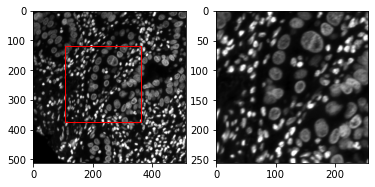

In [9]:
ij = np.unravel_index(np.argmax(heatmap_ncc), heatmap_ncc.shape)
match_x, match_y = ij[::-1]

fig, (ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(img1, cmap='gray')
rect = plt.Rectangle((match_x, match_y), 256, 256, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

ax2.imshow(img2_template, cmap='gray')

### (d) Warp img2

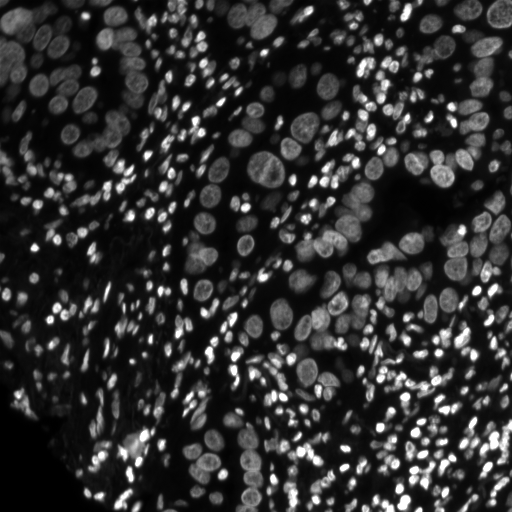

In [10]:
A = np.ones([2,3])
A[1,0] = 0
A[0,1] = 0
A[0,2] = -crop_start[0] + match_x
A[1,2] = -crop_start[1] + match_y

img2_trans = cv2.warpAffine(img2, A, img1.shape)

dispGif(img1, img2_trans)

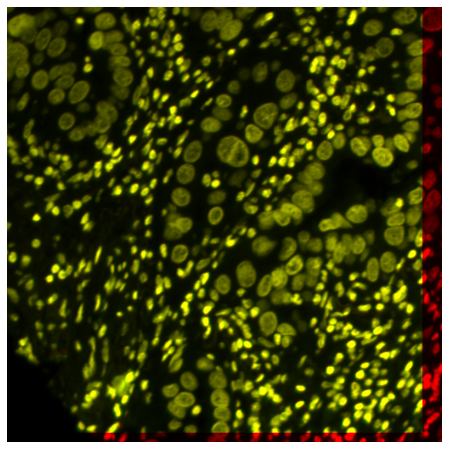

In [11]:
# Note that the rgb visualization is not as sensitive to show the error
out = np.zeros([img1.shape[0], img1.shape[1], 3], np.uint8)
out[:,:, 0] = img1
out[:,:, 1] = img2_trans

plt.figure(figsize=(8, 8)) 
plt.imshow(out);plt.axis('off')
plt.show()

## 2.2 3-Step Pipeline

Lec. 5, page 47-49

### (a) Step 1. Get the key points

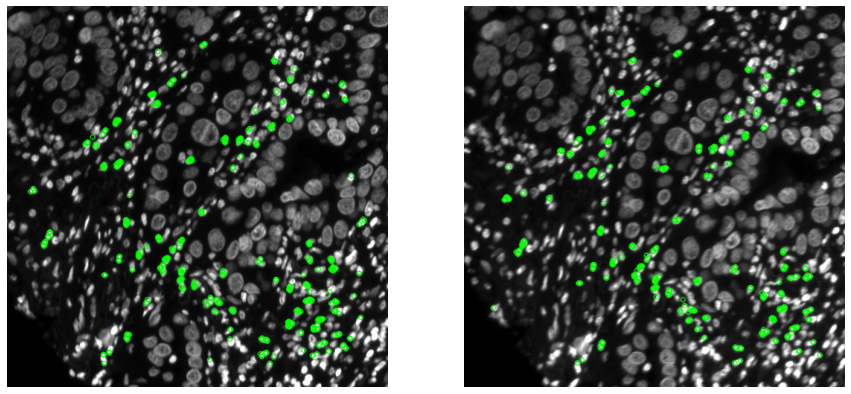

In [12]:
import cv2
def get_orb_features(img):
    '''
    Compute ORB features using cv2 library functions (hint: you will need cv2.ORB_create() and some related functions).  Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
    '''
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors


kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)
                            
plotImgPair(kp_img1, kp_img2)

### (b) Step 2. Find matches among key points

orb feature matches


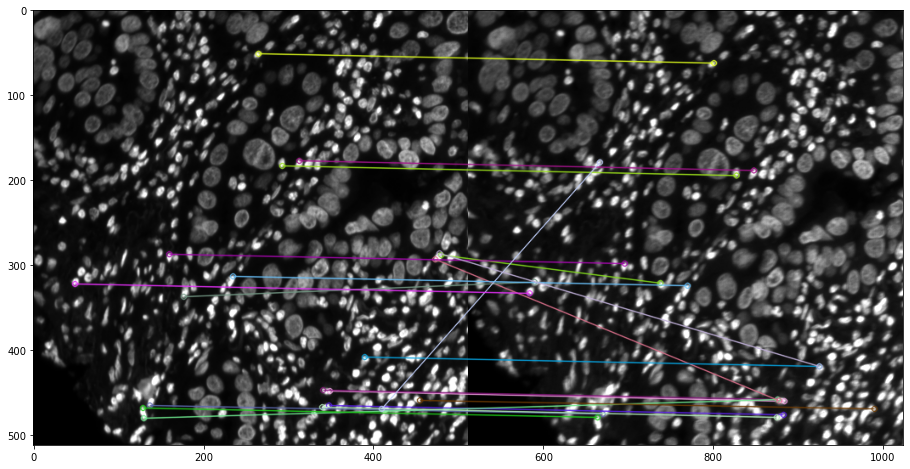

In [13]:
def match_keypoints(desc_1, desc_2):
    '''
    Compute matches between feature descriptors of two images using ratio test. 
    You may use cv2 library functions.(hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher and some related functions)
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
    '''
    matcher = cv2.DescriptorMatcher_create("BruteForce-Hamming")
    matches = matcher.match(desc_1, desc_2)
    return matches

# display the top-20 matches
# note that some matches are quite off (e.g., big tree branches in the left image)
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")

plt.figure(figsize=(16, 8))
plt.imshow(match_plot)

### (c) Step 3. Estimate transformation

In [14]:
pts_1 = np.vstack([kp_1[m.queryIdx].pt for m in matches])
pts_2 = np.vstack([kp_2[m.trainIdx].pt for m in matches])

T_aff, status = cv2.estimateAffine2D(pts_2, pts_1, cv2.RANSAC)

print(T_aff)
print('Number of input pairs: %d\nNumber of matched pairs: %d' % (len(status), status.sum()))

[[ 1.00001129e+00 -1.47833741e-03 -2.24046964e+01]
 [-1.03663927e-03  1.00316250e+00 -1.17795180e+01]]
Number of input pairs: 500
Number of matched pairs: 349


# [5 pts] Exercise
As pset1 is out, we'll make this lab light-weight :)

## (1) [1 pt] Visualize an affine transformation

In sec. 1.2, we showed how to plot the forward warping with translation, scale, and rotation.

TODO: Make arbitrary affine transformation and plot the blue and red points for it

In [15]:
### Your code starts here

### Your code ends here

## (2) [2 pts] Bilinear interpolation

Lec. 5, page 34-35

In [16]:
def bilinearInterp(mat, pos):
    # mat: [[I0,I1],[I2,I3]], 2x2 numpy matrix with values at four corners
    # pos: (y,x), numpy array for the position. 0 <= x,y <= 1
    val = 0 
    ### Your code starts here

    ### Your code ends here
    return val

## test case

test_mat = np.array([[50,100],[150,200]])
test_pos = [0.7, 0.3]

print(bilinearInterp(test_mat, test_pos))

0


## (3) [2 pts] Visualize the 3-step pipeline results in sec. 2.2

- Run through sec. 2.2
- Visualize both the RGB and Gif results here. 

Hints: well, sometimes, simple methods (e.g., template matching) are more robust... 

In [17]:
### Your code starts
### Your code ends